⬇️ Downloading dataset...
Using Colab cache for faster access to the 'vehicle-dataset-from-cardekho' dataset.
Path to dataset files: /kaggle/input/vehicle-dataset-from-cardekho
✅ Loaded car data.csv
Dataset Shape: (301, 9)


,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0



Numerical Features: ['Year', 'Present_Price', 'Kms_Driven', 'Owner']
Categorical Features: ['Fuel_Type', 'Seller_Type', 'Transmission']

Multiple Linear Regression
----------------------------------------
MAE : 1.2162256821297064
RMSE: 1.8651552135513823
R²  : 0.8489813024899067

Best Ridge Alpha: {'regressor__alpha': 10}

Ridge Regression
----------------------------------------
MAE : 1.22306933076975
RMSE: 1.8815264738172632
R²  : 0.8463185569023877

Best Lasso Alpha: {'regressor__alpha': 0.001}

Lasso Regression
----------------------------------------
MAE : 1.2155555561227613
RMSE: 1.8642558304273702
R²  : 0.8491269106620155


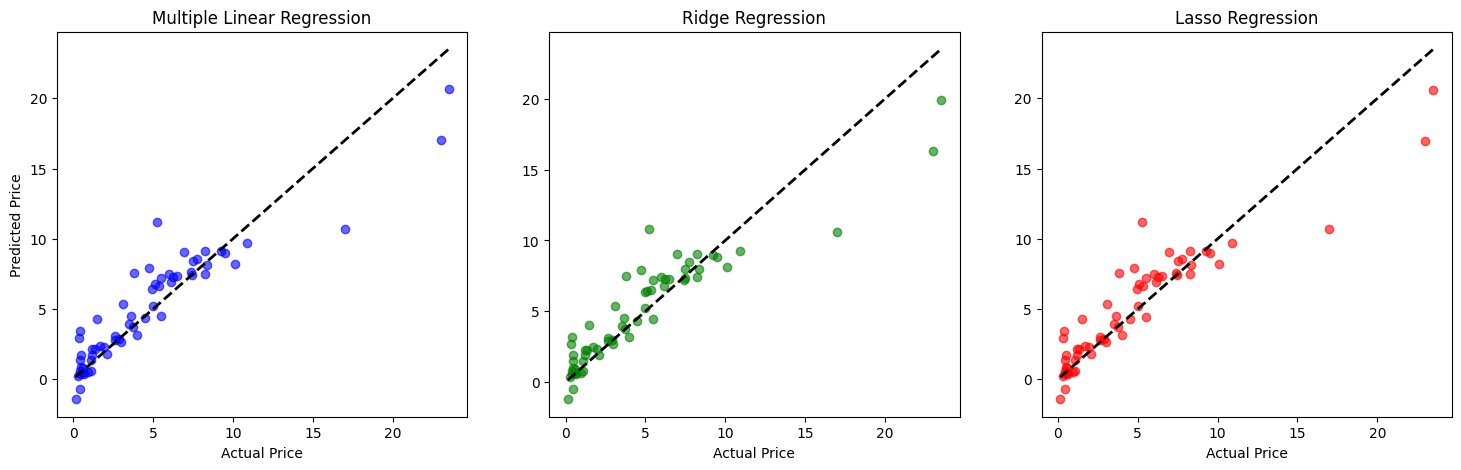

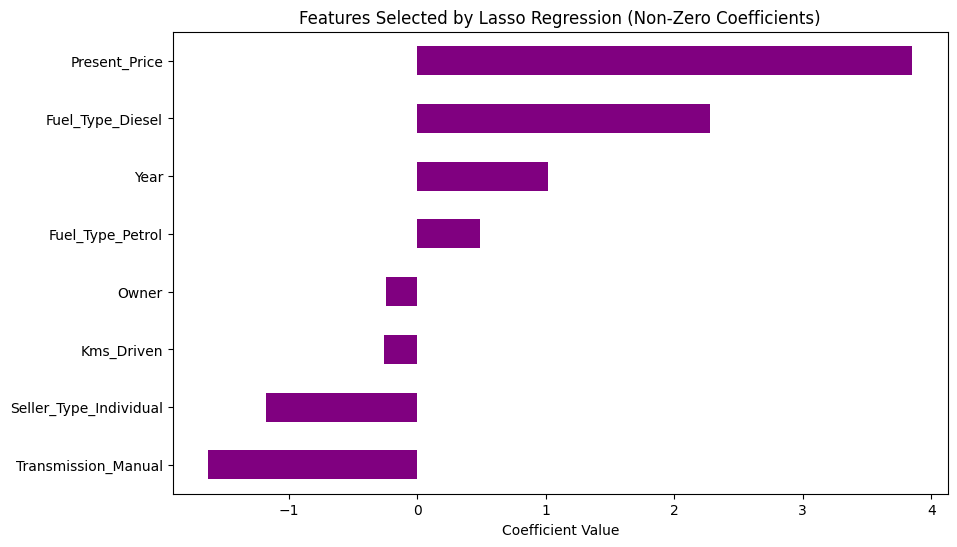

In [ ]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================================
# 1. LOAD DATASET FROM KAGGLE
# ==========================================
print("⬇️ Downloading dataset...")
# Download the dataset
path = kagglehub.dataset_download("nehalbirla/vehicle-dataset-from-cardekho")

print("Path to dataset files:", path)

# Load the specific CSV file (usually 'car data.csv')
# We use a try-except block to find the right file in the downloaded folder
import os
csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, csv_file))

print(f"✅ Loaded {csv_file}")
print("Dataset Shape:", df.shape)
display(df.head())

# ==========================================
# 2. PREPROCESSING
# ==========================================
# Drop Car_Name as it has too many unique values and causes overfitting
df = df.drop(columns=['Car_Name'], errors='ignore')

# Separate Features and Target
X = df.drop("Selling_Price", axis=1)
y = df["Selling_Price"]

# Identify Numerical and Categorical columns
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

print(f"\nNumerical Features: {list(num_features)}")
print(f"Categorical Features: {list(cat_features)}")

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create a Preprocessing Pipeline
# Standardize numbers, One-Hot Encode text categories
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
    ]
)

# ==========================================
# 3. DEFINE MODELS & EVALUATION
# ==========================================
def evaluate(name, y_true, y_pred):
    print(f"\n{name}")
    print("-" * 40)
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R²  :", r2_score(y_true, y_pred))

# --- Model 1: Multiple Linear Regression ---
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
evaluate("Multiple Linear Regression", y_test, y_pred_lr)

# --- Model 2: Ridge Regression (Grid Search) ---
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

ridge_params = {"regressor__alpha": [0.01, 0.1, 1, 10, 100]}

ridge_grid = GridSearchCV(
    ridge_pipeline,
    ridge_params,
    cv=5,
    scoring="neg_mean_squared_error"
)

ridge_grid.fit(X_train, y_train)
ridge_best = ridge_grid.best_estimator_
y_pred_ridge = ridge_best.predict(X_test)

print("\nBest Ridge Alpha:", ridge_grid.best_params_)
evaluate("Ridge Regression", y_test, y_pred_ridge)

# --- Model 3: Lasso Regression (Grid Search) ---
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(max_iter=10000))
])

lasso_params = {"regressor__alpha": [0.001, 0.01, 0.1, 1, 10]}

lasso_grid = GridSearchCV(
    lasso_pipeline,
    lasso_params,
    cv=5,
    scoring="neg_mean_squared_error"
)

lasso_grid.fit(X_train, y_train)
lasso_best = lasso_grid.best_estimator_
y_pred_lasso = lasso_best.predict(X_test)

print("\nBest Lasso Alpha:", lasso_grid.best_params_)
evaluate("Lasso Regression", y_test, y_pred_lasso)

# ==========================================
# 4. VISUALIZATION
# ==========================================
# Scatter Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(y_test, y_pred_lr, color='blue', alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[0].set_title("Multiple Linear Regression")
axes[0].set_xlabel("Actual Price")
axes[0].set_ylabel("Predicted Price")

axes[1].scatter(y_test, y_pred_ridge, color='green', alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[1].set_title("Ridge Regression")
axes[1].set_xlabel("Actual Price")

axes[2].scatter(y_test, y_pred_lasso, color='red', alpha=0.6)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[2].set_title("Lasso Regression")
axes[2].set_xlabel("Actual Price")

plt.show()

# Feature Importance (Lasso)
# We need to extract feature names after OneHotEncoding
feature_names = (num_features.tolist() +
                 list(lasso_best.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .get_feature_names_out(cat_features)))

lasso_coeffs = pd.Series(
    lasso_best.named_steps['regressor'].coef_,
    index=feature_names
)

#
selected = lasso_coeffs[lasso_coeffs != 0].sort_values()
plt.figure(figsize=(10, 6))
selected.plot(kind="barh", color='purple')
plt.title("Features Selected by Lasso Regression (Non-Zero Coefficients)")
plt.xlabel("Coefficient Value")
plt.show()